In [1]:
import os
from pyprojroot.here import here
from tqdm.auto import trange, tqdm

import pandas as pd
import anndata as ad
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns

import sparse

import pickle

from collections import defaultdict

import re

In [2]:
CELL_TYPES=["Mono", "T_CD4_Naive", "T_CD4_NonNaive", "T_CD8_Naive", "T_CD8_NonNaive", "B", "Plasma", "UTC", "ILC", "pDC", "DC"]

CELL_TYPE = 'pDC'

adata = ad.read_h5ad(here(f'03_downstream_analysis/05_SHAP/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed = 'r')
genes = adata.var_names
disease = adata.obs.disease.cat.categories

N_GENES = len(genes)
N_DISEASES = len(disease)

annot = (pd.DataFrame(adata.var_names)
.merge(
    pd.read_pickle(here("03_downstream_analysis/04_selected_gene_list.pkl")), 
    left_on='ensembl_gene_id', 
    right_index=True))

In [3]:
def load_shap_statistics(
    cell_type: str = '',
    interactions: bool = False, 
    run_name: str = 'run1',
):

    if interactions:
        shap_type = 'shap_int'
    else:
        shap_type = 'shap'

    fname = here(f"03_downstream_analysis/05_SHAP/results/04_shap/shap_vals/total_{run_name}_{cell_type}_{shap_type}_stats.npz")

    shap_stats = np.load(fname)

    return (
        shap_stats['mean_raw'],
        shap_stats['var_raw'],
        shap_stats['mean_abs'],
        shap_stats['var_abs'])


In [4]:
shap_diag_per_cell_type = {}

for cell_type in CELL_TYPES:

    mean_raw, var_raw, mean_abs, var_abs = load_shap_statistics(cell_type, interactions=True)

    shap_colsum = []
    for j in trange(0, len(disease), leave=False):
        shap_colsum.append(np.diagonal(mean_abs[:, :, j]))    
    shap_gene_disease = np.stack(shap_colsum)
    shap_gene_disease = pd.DataFrame(shap_gene_disease.T, index=genes, columns= disease)
    shap_gene_disease = shap_gene_disease.merge(annot.set_index("ensembl_gene_id").loc[:,"symbol"], left_index=True, right_index=True).set_index('symbol')

    shap_diag_per_cell_type[cell_type] = shap_gene_disease

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Mono


<Figure size 1500x1000 with 0 Axes>

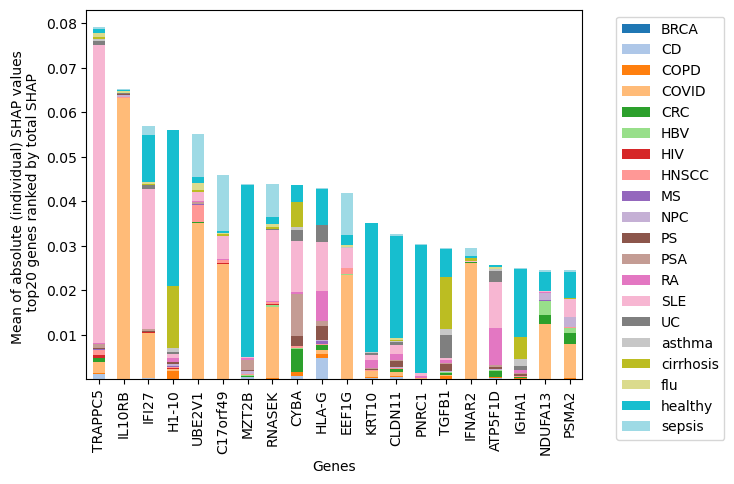

T_CD4_Naive


<Figure size 1500x1000 with 0 Axes>

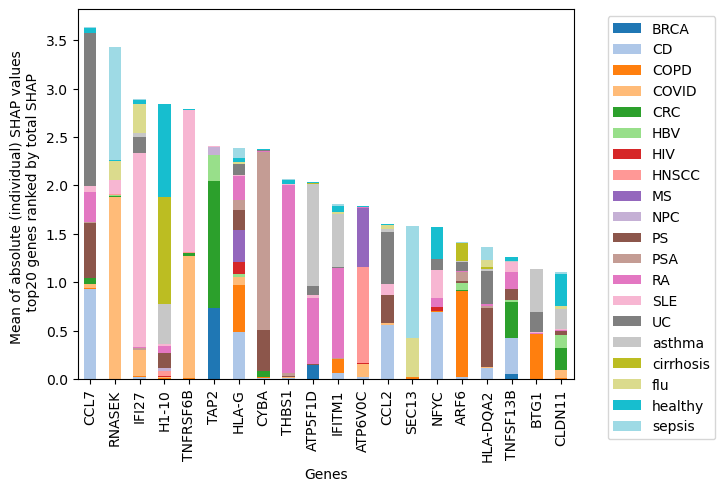

T_CD4_NonNaive


<Figure size 1500x1000 with 0 Axes>

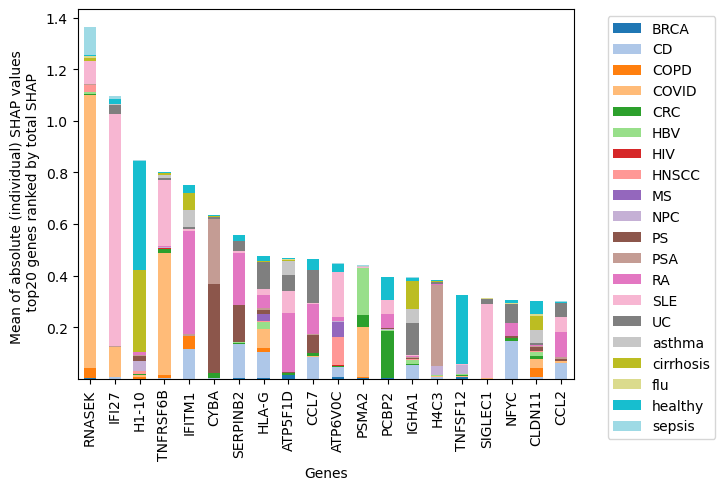

T_CD8_Naive


<Figure size 1500x1000 with 0 Axes>

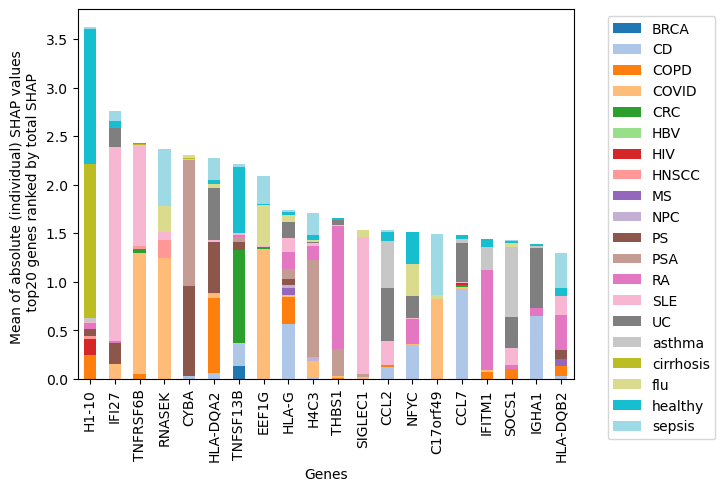

T_CD8_NonNaive


<Figure size 1500x1000 with 0 Axes>

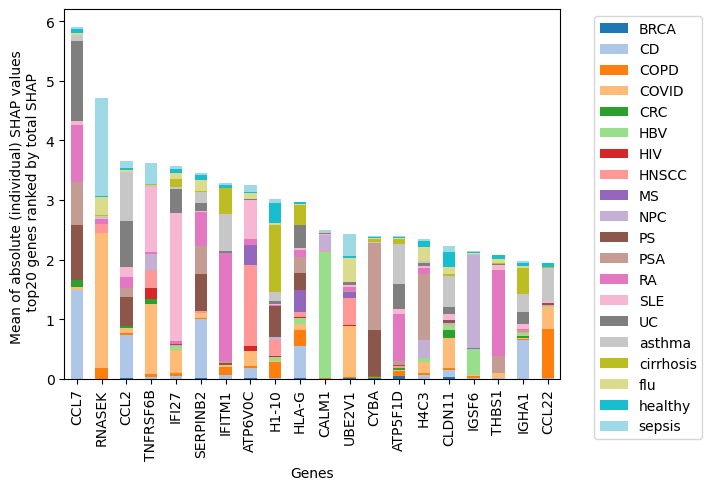

B


<Figure size 1500x1000 with 0 Axes>

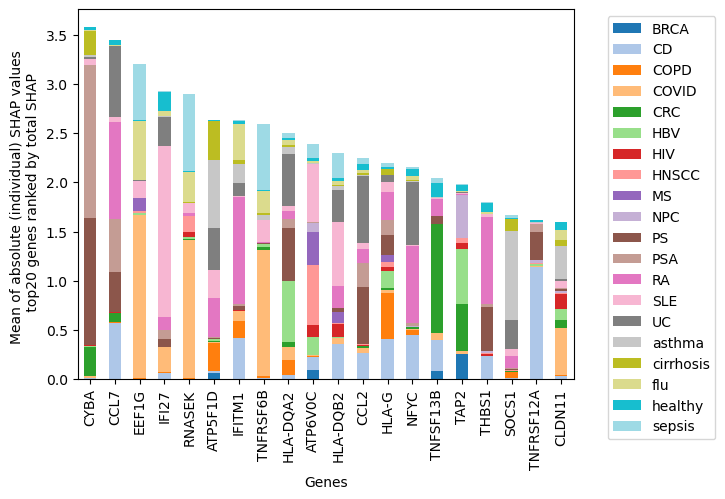

Plasma


<Figure size 1500x1000 with 0 Axes>

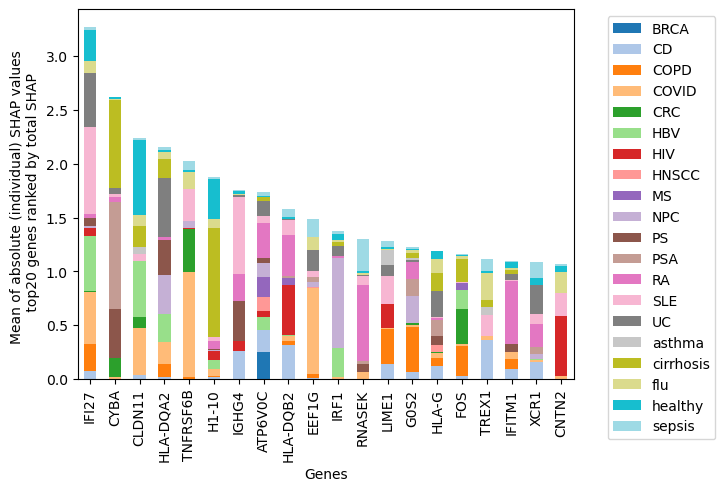

UTC


<Figure size 1500x1000 with 0 Axes>

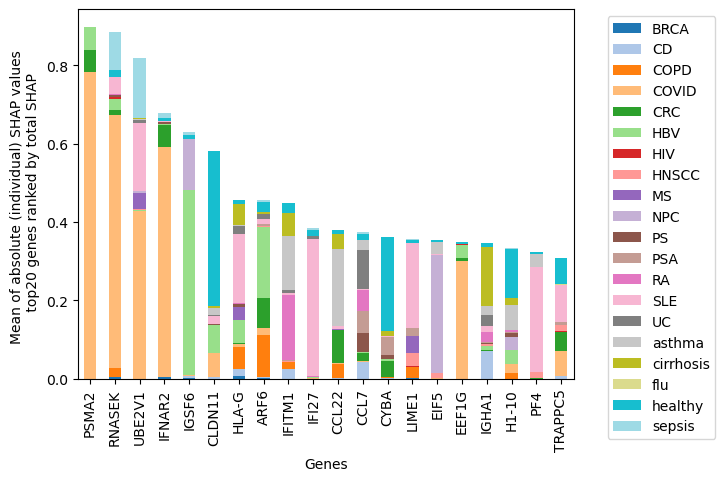

ILC


<Figure size 1500x1000 with 0 Axes>

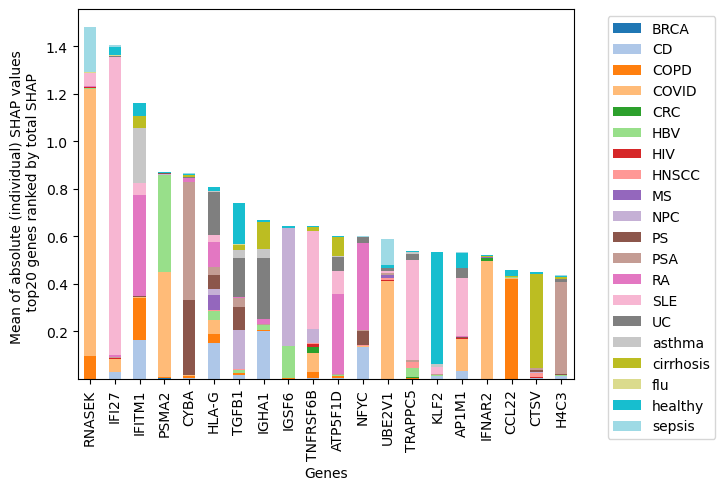

pDC


<Figure size 1500x1000 with 0 Axes>

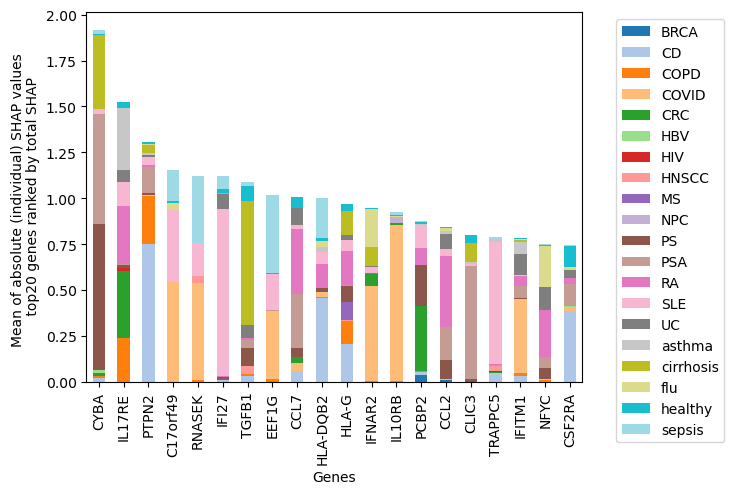

DC


<Figure size 1500x1000 with 0 Axes>

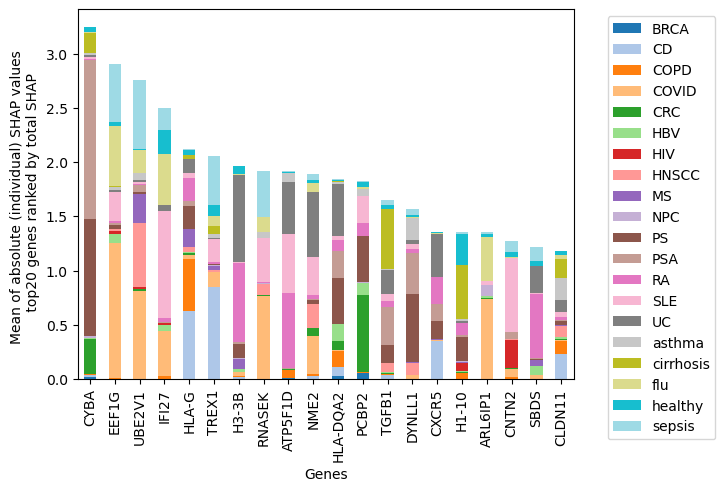

In [5]:
for cell_type in shap_diag_per_cell_type:
    print(cell_type)
    array = shap_diag_per_cell_type[cell_type]
    to_plot = array.loc[array.sum(axis=1).sort_values(ascending=False).index]
    to_plot = to_plot.loc[(to_plot!=0).any(axis=1)].head(20) 

    plt.figure(figsize = (15,10))
    to_plot.plot(kind='bar', stacked = True, colormap='tab20')
    plt.ylabel('Mean of absolute (individual) SHAP values \n top20 genes ranked by total SHAP')
    plt.xlabel('Genes')
    plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right")
    plt.savefig(here(f'03_downstream_analysis/05_SHAP/results/04_shap/shap_statistics_full/stacked_barplot_{cell_type}_ind_shap_total_top20genes_per_disease.png'), bbox_inches='tight')
    plt.show() 

In [8]:
array = shap_diag_per_cell_type['B']

to_plot = array.loc[array.sum(axis=1).sort_values(ascending=False).index]
